# Enhance reproducability of results

In [0]:
#%env PYTHONHASHSEED=0 
#%env CUDA_VISIBLE_DEVICES=""

In [0]:
import numpy as np
import tensorflow as tf
import random
import os
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

In [0]:
def resetRNG(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.set_random_seed(seed_value)

# Import .npz Database containing 5SS mechanisms and cplr paths

In [0]:
# Import data offline
#current_dir=os.getcwd()
#db_path=os.path.join(current_dir,'..','1. DB Preprocessing','norm_database5SS.npz')
#db = np.load(db_path)

In [6]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks
db = np.load('norm_database5SS.npz')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [7]:
print(db.files)
cplr=db['cplrData']
mech=db['mechData']

print(cplr.shape)
print(mech.shape)

['cplrData', 'mechData']
(1453, 100, 3)
(1453, 11, 3)


# Splitting the database in Train/Test dataset

In [0]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=11)

# Functions to TRAIN an Autoencoder

In [0]:
from keras.layers import Input, Dense, Flatten, Reshape, concatenate, Conv2D, Conv1D, SeparableConv1D, Lambda
from keras.models import Model, load_model
from keras.layers import LeakyReLU
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K 
#from keras import initializers
import keras

In [0]:
# Train same model architecture multiple times since the training process is stochastic

def AE_analysis(AE_model, iterations, x_train, x_test, filename='model'):
    val_loss_list=[]
    best_val_loss=np.inf;
    for i in range(iterations):
        print('Model no. '+str(i+1))
        AE, E = AE_model()
        val_loss, train_data=train_AE(AE, E, x_train, x_test)
        val_loss_list.append(val_loss)
        if best_val_loss>val_loss:
            best_AE=AE
            best_E=E
            best_train_data=train_data
            best_val_loss=val_loss
    
    # PRINT MEAN, VARIANCE and BEST MODEL METRICS
    print(val_loss_list)
    print('Average Validation Loss: '+str(np.mean(val_loss_list)))
    
    # SAVE BEST MODEL
    AEfilename='AE_'+filename+'_val_loss_'+str(best_val_loss)+'.h5'
    AEfilepath=os.path.join('models',AEfilename)
    best_AE.save(AEfilepath)
    
    return best_AE, best_E, best_train_data

In [0]:
def train_AE(autoencoder, encoder, x_train, x_test, epochs=1000):
    # TRAINING PHASE
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min',
                                  restore_best_weights=True)
    autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=128, 
                                      shuffle=False, validation_data=(x_test, x_test), 
                                      verbose=0, callbacks=[earlyStopping])
    
    # TRAINING HISTORY
    val_loss = autoencoder_train.history['val_loss']
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    return f_val_loss, autoencoder_train

# Functions to VISUALIZE an Autoencoder

In [0]:
def visualize_AE(AE, train_data, x_test):
    # VISUALIZING TRAINING CURVES
    visualize_train_curves(train_data)
    
    # VISUALIZE RECONSTRUCTED CURVES
    reconst_curve = AE.predict(x_test)
    visualize_reconstructed_CplrCurves(x_test, reconst_curve, 10)

    
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure(figsize=(14, 7))
    plt.plot(epochsRange, loss, 'r', label='Training loss')
    plt.plot(epochsRange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def visualize_reconstructed_CplrCurves(x_test, reconst_curve, n=10, b_spline=False):
    fig= plt.figure(figsize=(3*4, 3*n))
    fig.suptitle('Isometric (3D), Top (X-Y Plane), Front (X-Z Plane) and Right (Y-Z Plane) View', fontsize=14, fontweight='bold')
    for i in range(n):
        # Isometric View
        ax = plt.subplot(n, 4, 4*i+1, projection='3d')
        if b_spline:
            reconst_curve[i]=b_spline_interpolation(reconst_curve[i], 100)
        plotPath3D(reconst_curve[i], ax, 2,'r' )
        plotPath3D(x_test[i], ax, 2)
        
        #x-y, x-z, y-z plane view
        xy_recon=reconst_curve[i,:,0:2]
        xy_orig=x_test[i,:,0:2]
        xz_recon=np.concatenate(([reconst_curve[i,:,0]], [reconst_curve[i,:,2]]),axis=0).T
        xz_orig=np.concatenate(([x_test[i,:,0]], [x_test[i,:,2]]),axis=0).T
        yz_recon=reconst_curve[i,:,1:3]
        yz_orig=x_test[i,:,1:3]
        
        # Top View
        ax = plt.subplot(n, 4, 4*i+2)
        plotPath(xy_recon, ax, 2,'r' )
        plotPath(xy_orig, ax, 2)
        
        # Front View
        ax = plt.subplot(n, 4, 4*i+3)
        plotPath(xz_recon, ax, 2,'r' )
        plotPath(xz_orig, ax, 2)
        
        # Right View
        ax = plt.subplot(n, 4, 4*i+4)
        plotPath(yz_recon, ax, 2,'r' )
        plotPath(yz_orig, ax, 2)
        
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [0]:
# Plotting Functions

%matplotlib inline
#%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import interpolate


def plotPath3D(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    
def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    ax.plot(xline, yline, color)
    ax.set(xlim=(-limit, limit), ylim=(-limit, limit))

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))


def b_spline_interpolation(inp_pts, out_n):
    # Fit cubic B-spline to the points
    xp=inp_pts[i,:,0]
    yp=inp_pts[i,:,1]
    zp=inp_pts[i,:,2]
        
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]
    
    tck, u =interpolate.splprep([xp,yp,zp],s=1)
    num_pts=out_n
    u_fine = np.linspace(0,1,num_pts)
    x_f, y_f, z_f = interpolate.splev(u_fine, tck)
    Path_f = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_f

## Visualize variation of coupler curves with change in z-space parameters

# 3. Convolutional Autoencoders

# Simplest Autoencoder (to compare results)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00426: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00388: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00496: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00465: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00411: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00503: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00542: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00373: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00536: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00474: early stopping
[0.0015, 0.0019, 0.0018, 0.0017, 0.0018, 0.0016, 

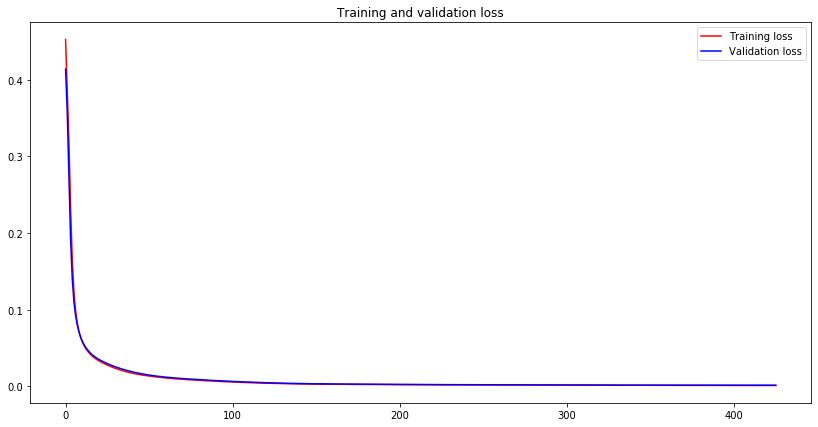

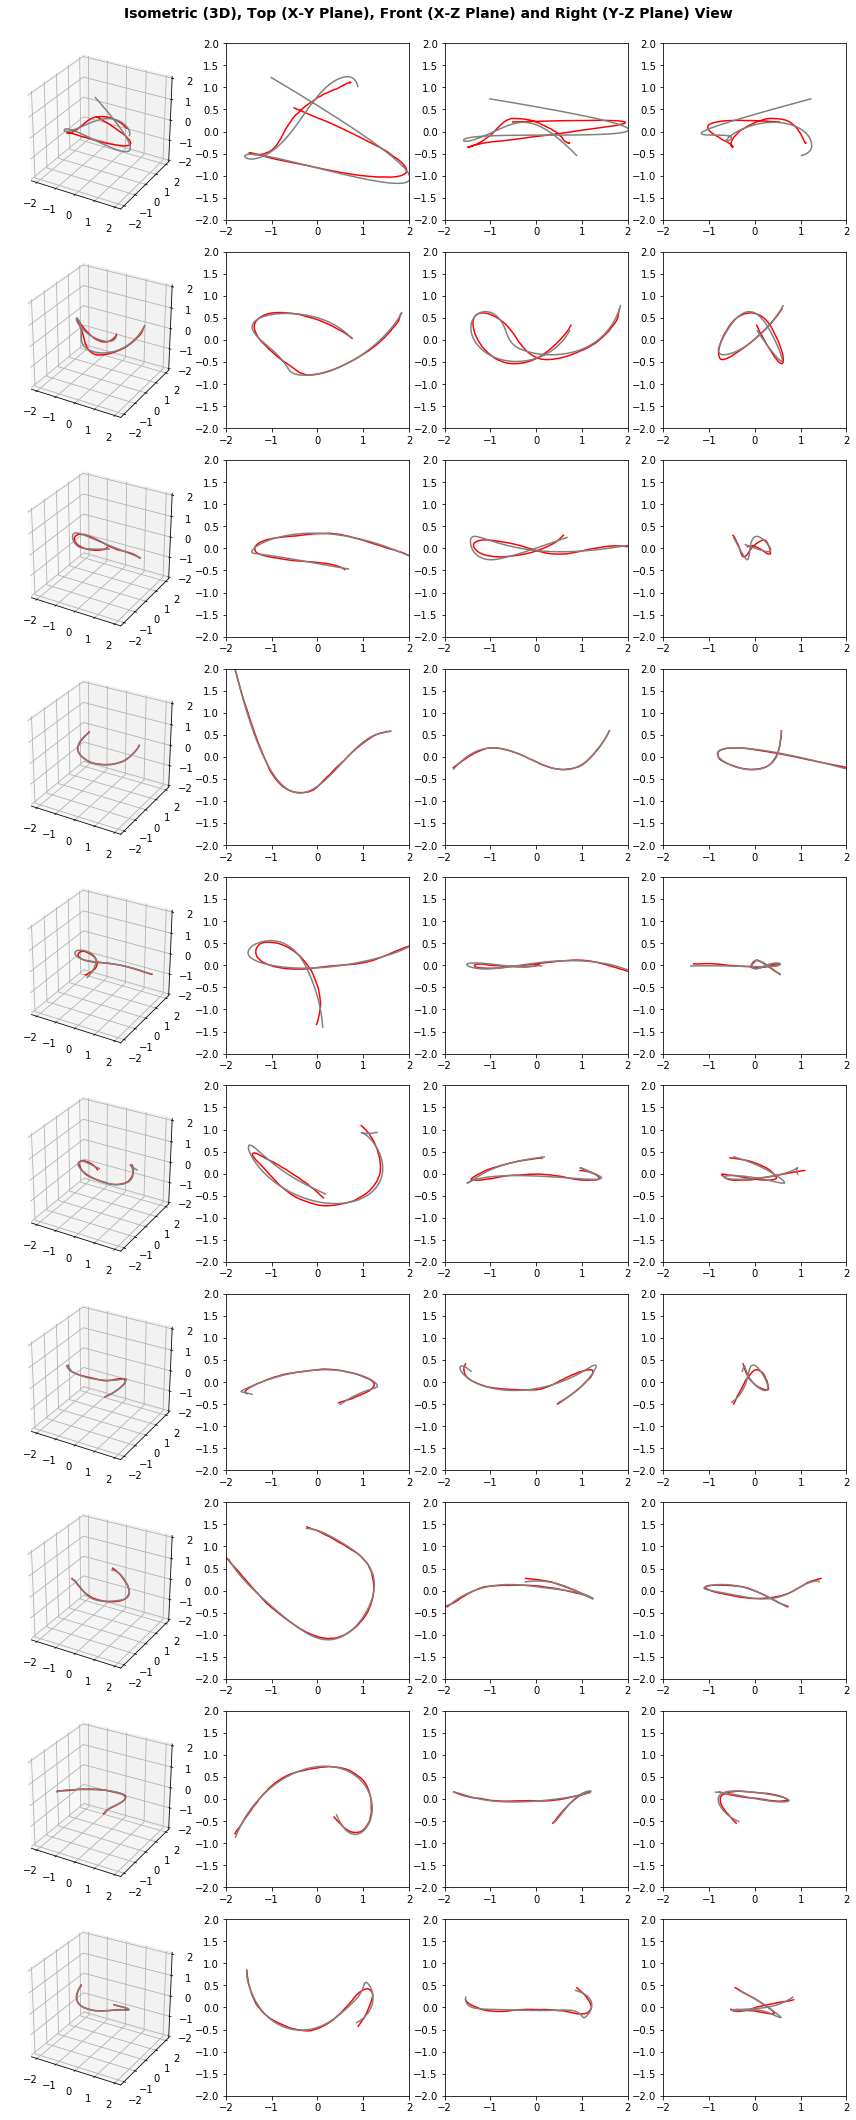

In [0]:
def autoEncoderZ30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp_curve)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(300)(encoded)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ30, 10, x_train, x_test, filename='Z30')
AE.summary()
visualize_AE(AE, train_data, x_test)

## 1D Convolution AutoEncoder Z=30 

Inspired to capture global convolutional features of curves like the Fourier coefficients by using full size kernels

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00128: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00171: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00127: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00189: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00137: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00143: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00159: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00187: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00125: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00147: early stopping
[0.0034, 0.0027, 0.0037, 0.004, 0.004, 0.0039, 0.

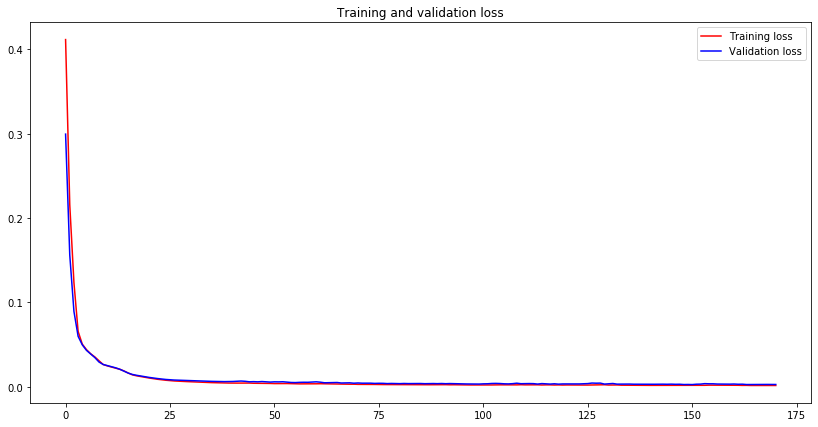

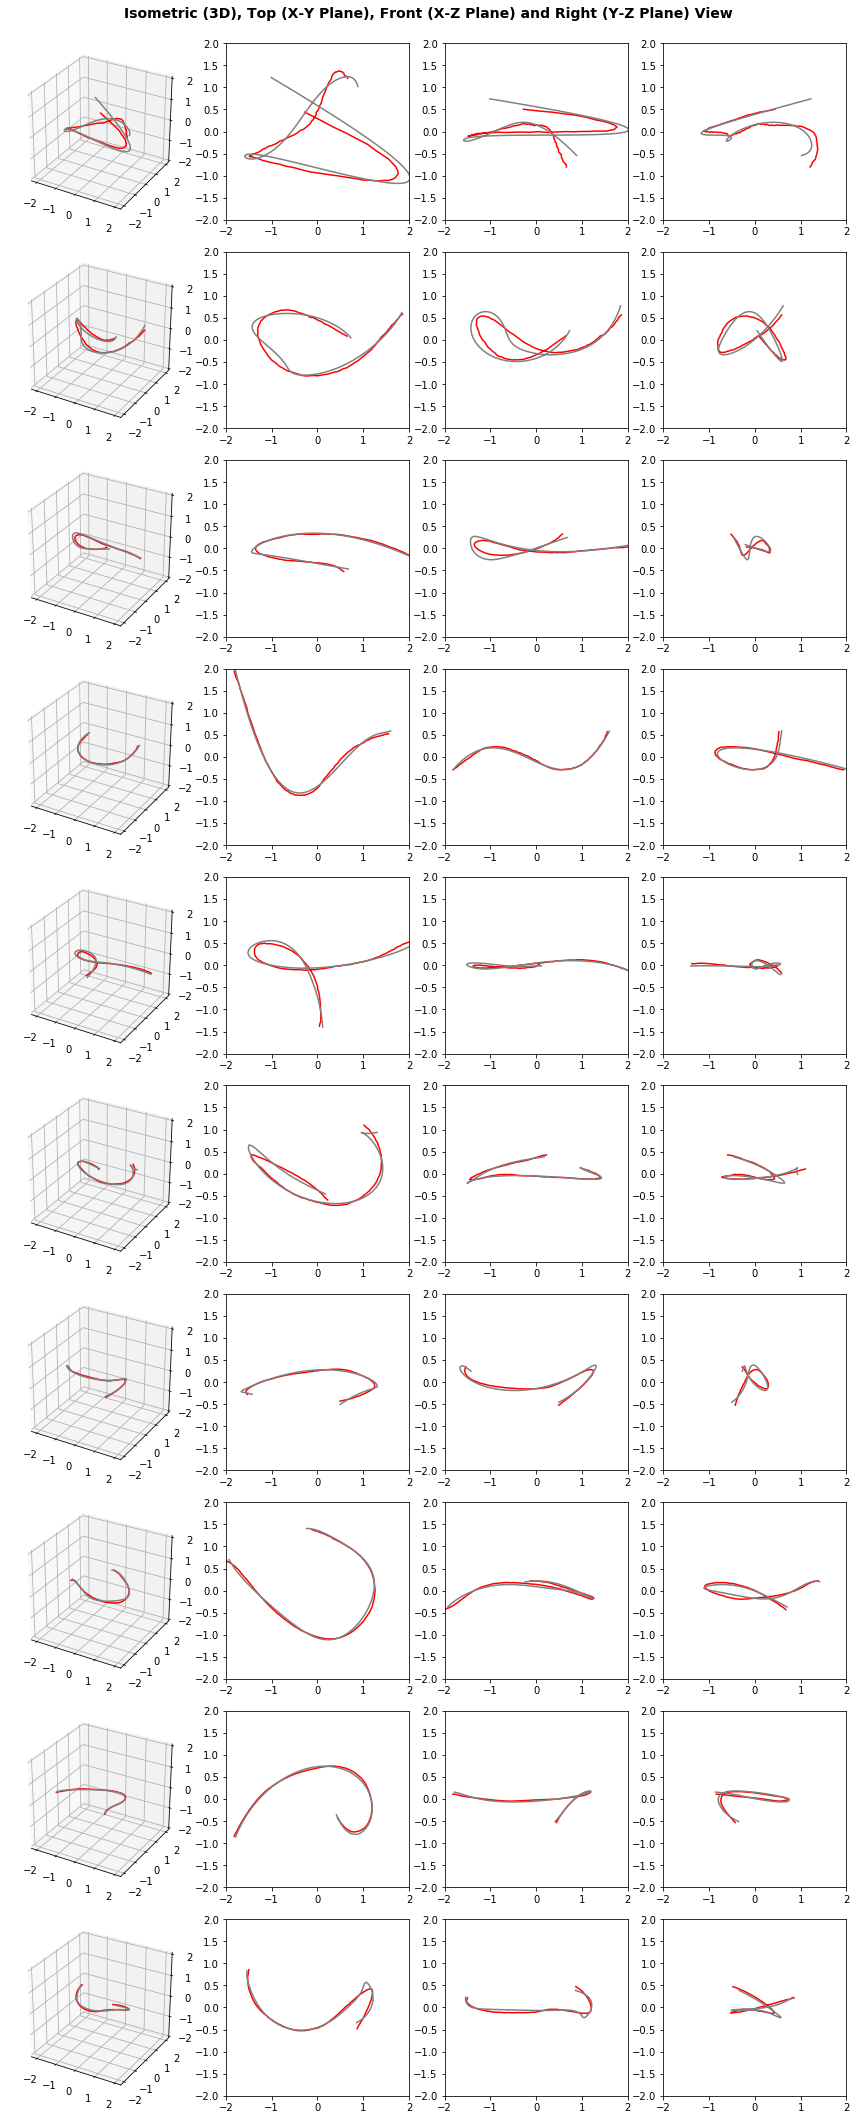

In [0]:
def autoEncoderCov_1D_Z30():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x = Conv1D(150, (100), activation='relu')(inp_curve)
    x = Flatten()(x)
    encoded=Dense(30, activation='relu')(x)
    #encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    x=Reshape((150, 1))(x)
    x=Conv1D(300, (150))(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderCov_1D_Z30, 10, x_train, x_test, filename='Cov_1D_Z30')
AE.summary()
visualize_AE(AE, train_data, x_test)

## 2D Convolution AutoEncoder Z=30 

Inspired to capture global convolutional features of curves like the Fourier coefficients by using full size kernels

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00240: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00229: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00309: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00231: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00256: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00296: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00107: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00298: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00210: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00215: early stopping
[0.0028, 0.0035, 0.0023, 0.003, 0.0027, 0.0027, 0

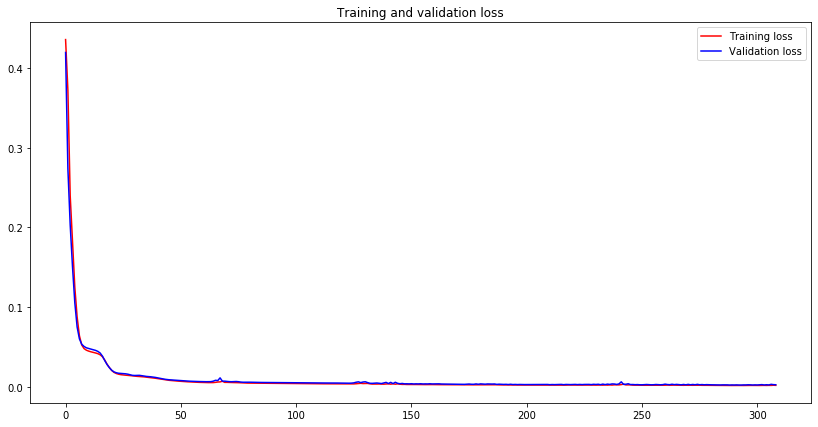

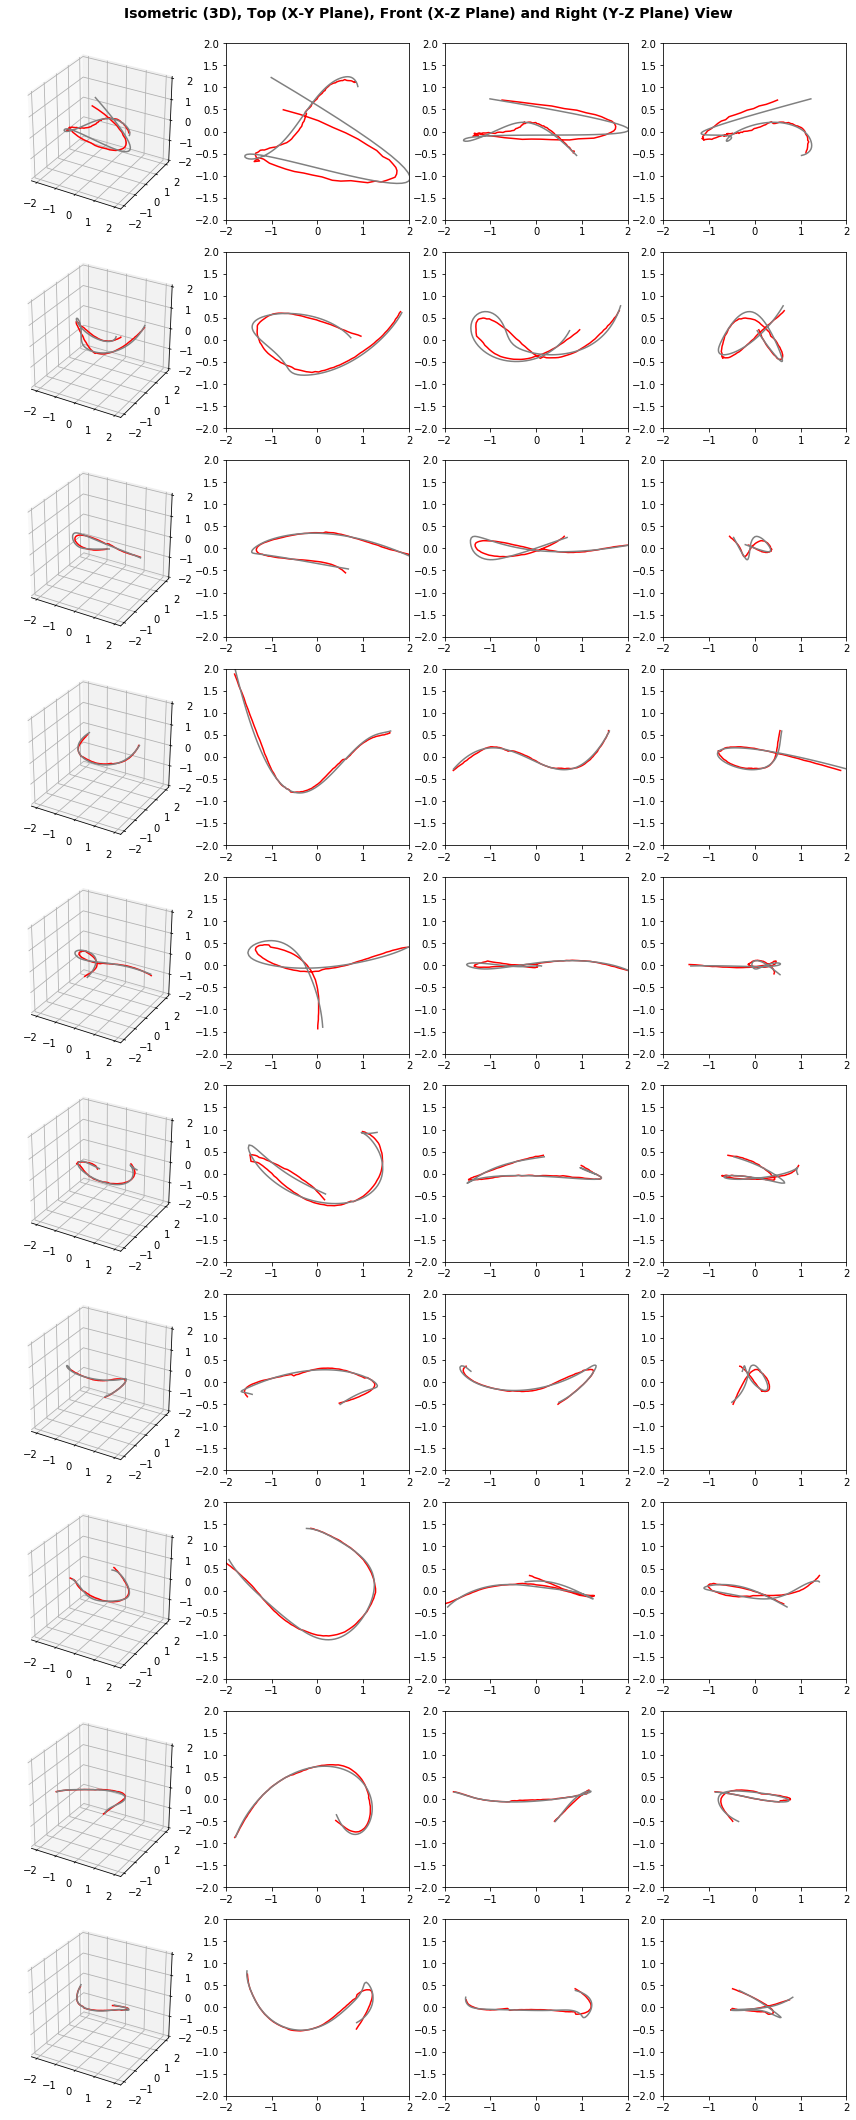

In [0]:
def autoEncoderCov_2D_Z30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x= Reshape((100, 3, 1))(inp_curve)
    x = Conv2D(50, (100,1), activation='relu')(x)
    x=Flatten()(x)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(150, activation='relu')(x)
    x=Reshape((3, 50, 1))(x)
    x=Conv2D(100, (1,50))(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
AE,E,train_data =AE_analysis(autoEncoderCov_2D_Z30, 10, x_train, x_test, filename='Cov_2D_Z30')
AE.summary()
visualize_AE(AE, train_data, x_test)

## Custom Convolution Autoencoder Z=30

Inspired to capture local convolutional features of curves like the Wavelet coefficients

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00164: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00139: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00110: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00162: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00131: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00132: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00093: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00212: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00119: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00153: early stopping
[0.0108, 0.0093, 0.0104, 0.01, 0.01, 0.0147, 0.01

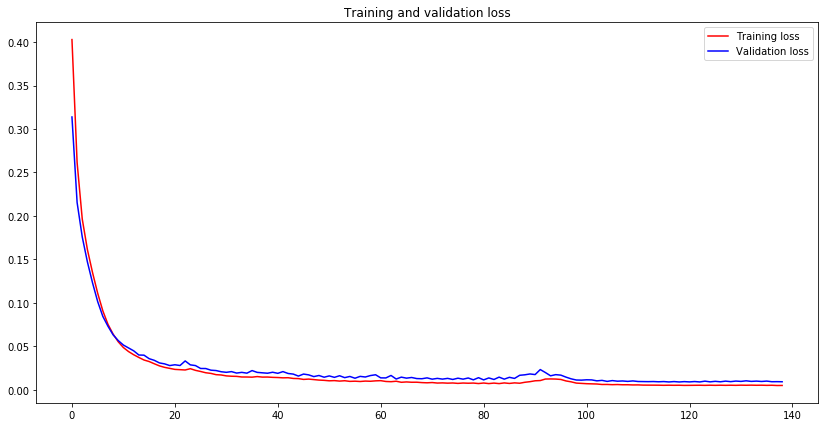

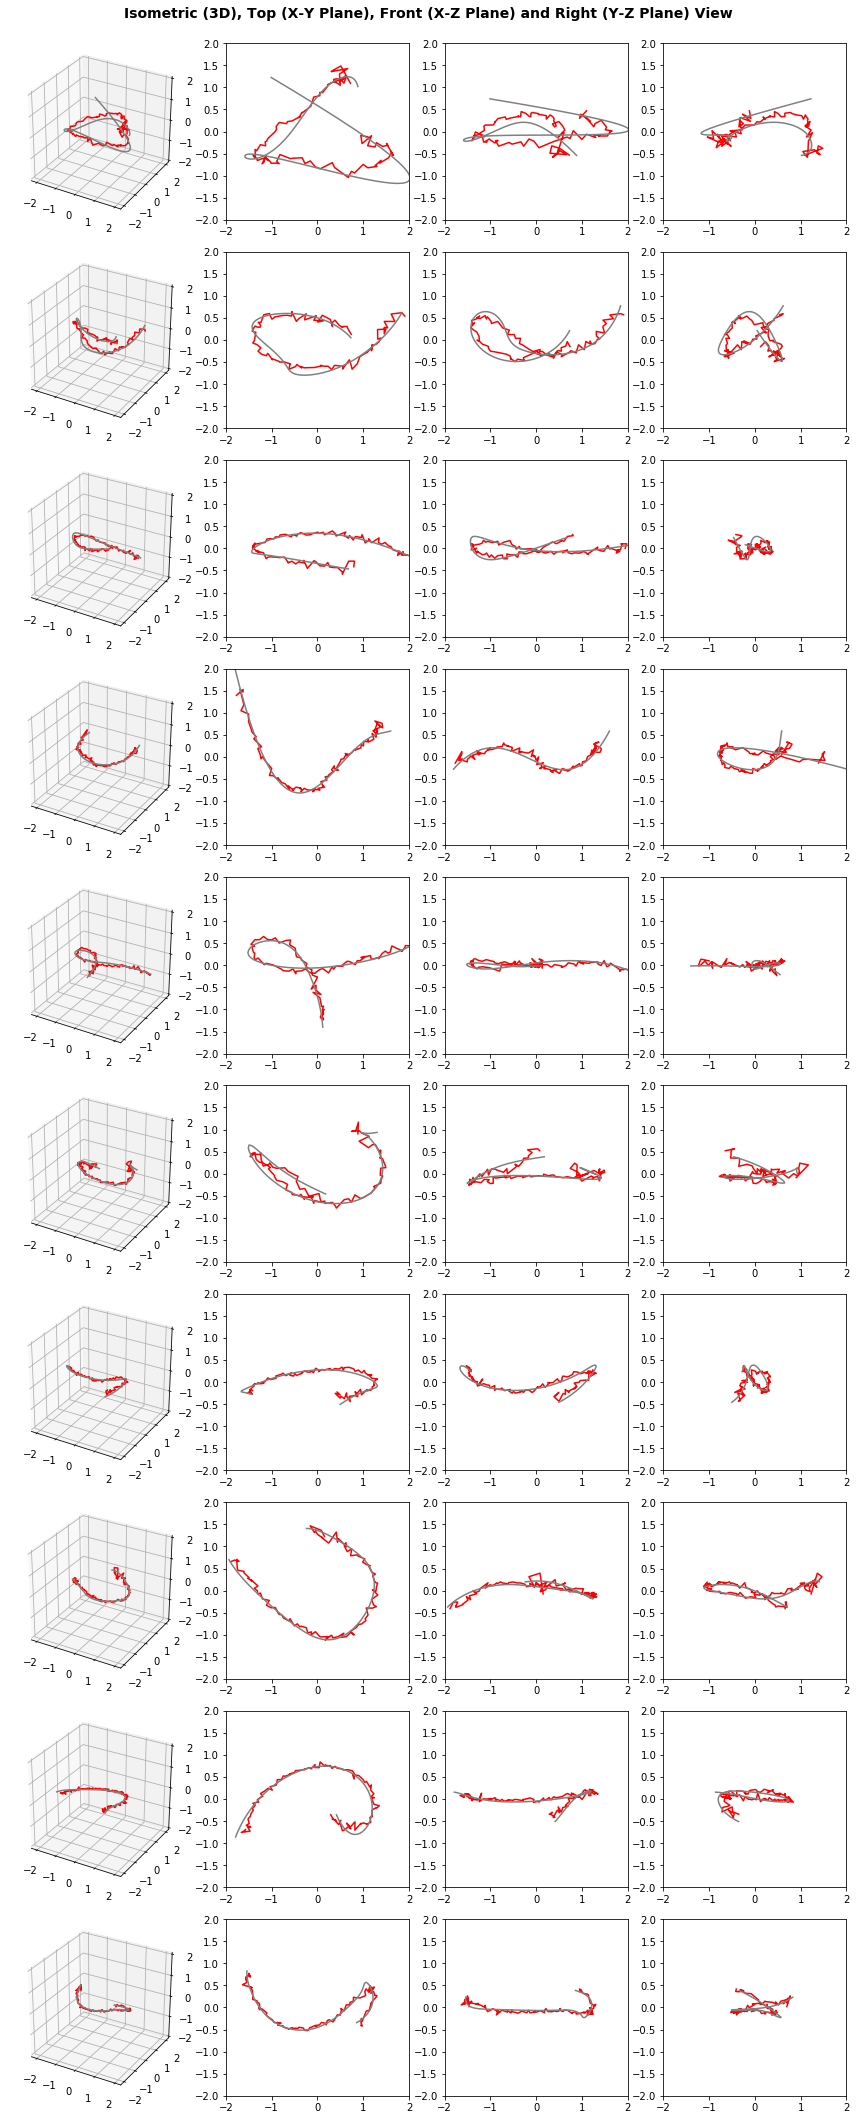

In [0]:
from keras.layers import Add, MaxPooling1D, UpSampling1D, MaxPooling2D

def autoEncoderCov_custom_Z30():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x= Reshape((100, 3, 1))(inp_curve)
    x1=Conv2D(4,(5,3), activation='relu')(x)
    x1=MaxPooling2D((2,1))(x1)
    x1=Flatten()(x1)
    x2=Conv2D(4,(20,3), activation='relu')(x)
    x2=MaxPooling2D((2,1))(x2)
    x2=Flatten()(x2)
    x3=Conv2D(4,(50,3), activation='relu')(x)
    x3=MaxPooling2D((2,1))(x3)
    x3=Flatten()(x3)
    x=concatenate([x1,x2,x3], axis=1)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(452, activation='relu')(x)
    x=UpSampling1D(2)(x)
    x=Dense(300,activation='relu')(x)
    x=Reshape((300, 1, 1))(x)
    x1=Conv2D(4,(5,1),padding='same', activation='relu')(x)
    x2=Conv2D(4,(20,1),padding='same', activation='relu')(x)
    x3=Conv2D(4,(50,1),padding='same', activation='relu')(x)
    x=Add()([x1, x2, x3])
    x=Conv2D(1,(5,1),padding='same')(x)
    decoded=Reshape((100,3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

AE,E,train_data =AE_analysis(autoEncoderCov_custom_Z30, 10, x_train, x_test, filename='Cov_custom_Z30')
AE.summary()
visualize_AE(AE, train_data, x_test)

## Pure FFT AutoEncoder Z=30

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00316: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00334: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00191: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00186: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00225: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00213: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00136: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00165: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00242: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00232: early stopping
[0.0017, 0.0017, 0.0023, 0.0027, 0.0018, 0.002, 0

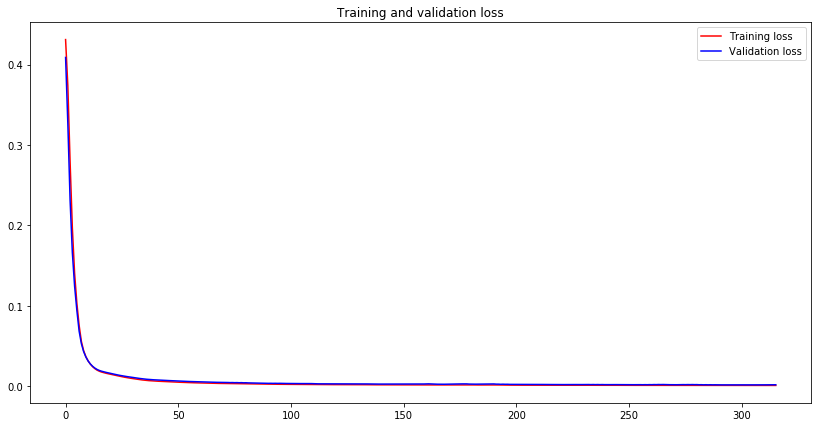

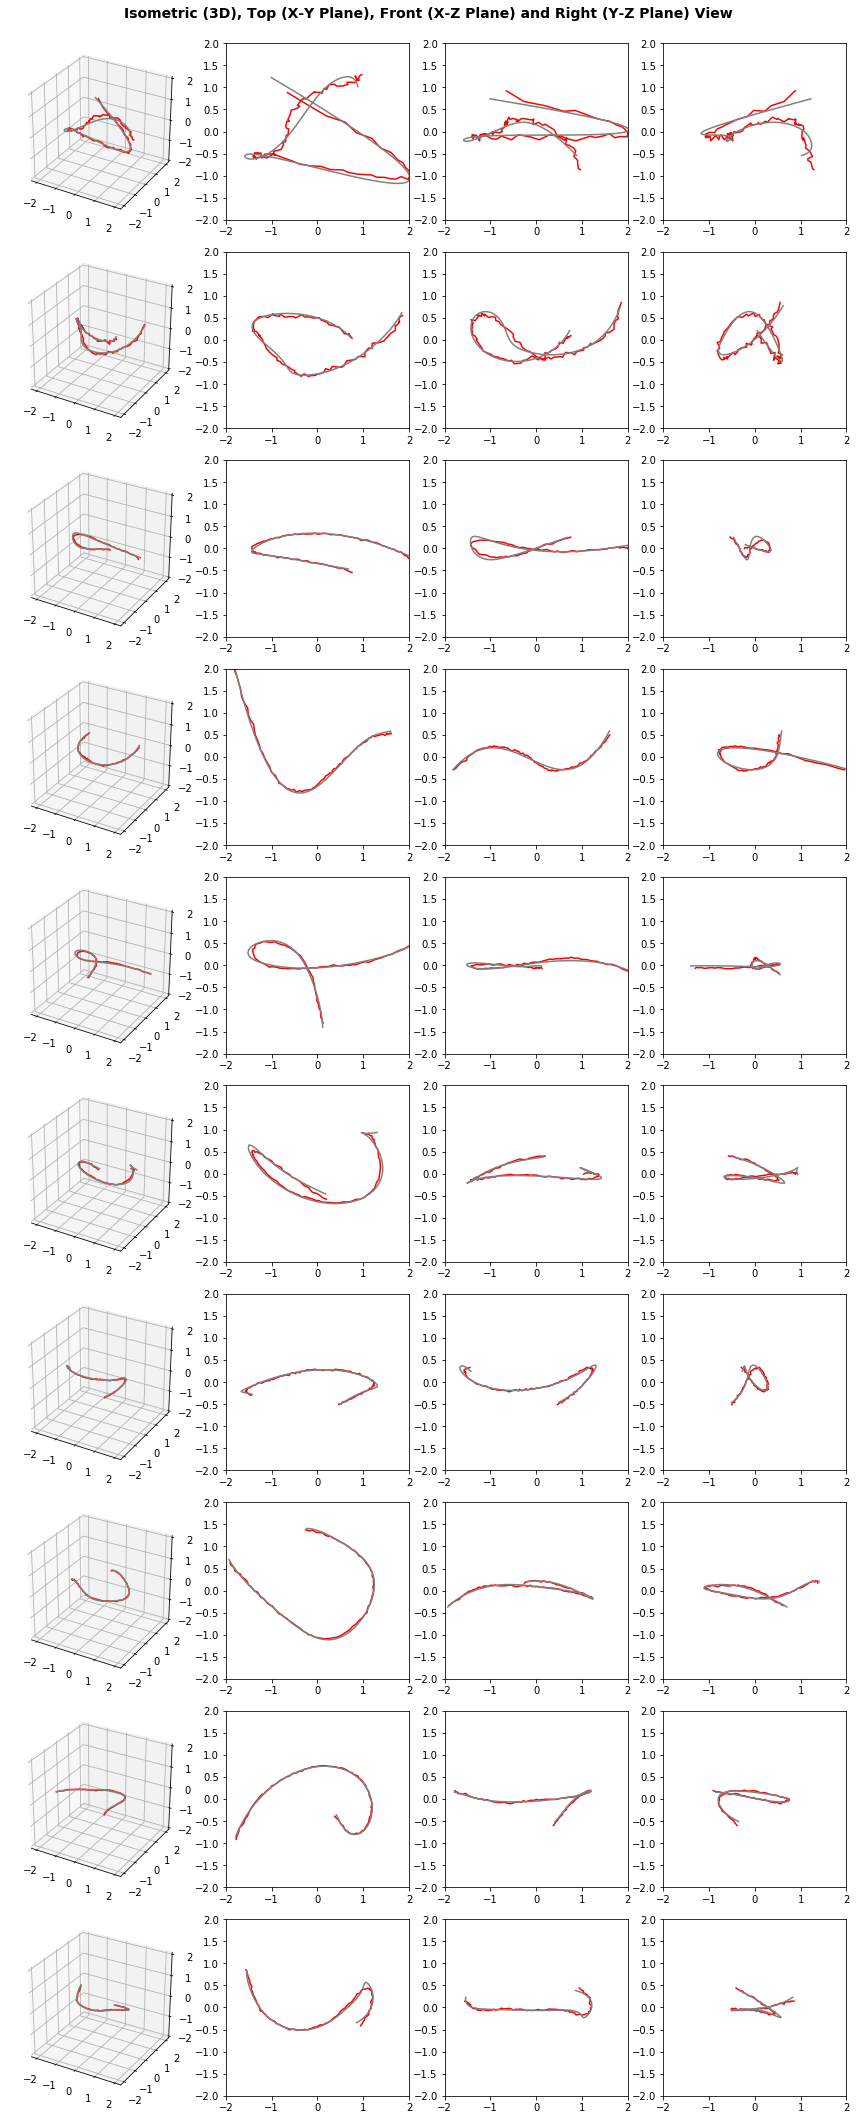

In [0]:
from keras.layers import Permute

def Fourier(x):
    #return tf.cast(tf.spectral.fft(tf.cast(x,dtype=tf.complex64)),dtype=tf.float32)
    FDs=tf.spectral.rfft(x)
    re=tf.cast(tf.real(FDs),dtype=tf.float32)
    im=tf.cast(tf.imag(FDs),dtype=tf.float32)
    return tf.concat([re,im],-1)

def invFourier(x):
    #return tf.cast(tf.spectral.ifft(tf.cast(x,dtype=tf.complex64)),dtype=tf.float32)
    re,im=tf.split(x,2,-1)
    FDs=tf.complex(re,im)
    curve=tf.spectral.irfft(FDs)
    return curve

def autoEncoderFFT_Z30():
    inp_curve=Input(shape=(100,3))

    # Encoding
    x= Permute((2, 1))(inp_curve)
    x = Lambda(Fourier)(x)
    x=Flatten()(x)
    x=Dense(150, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    x=Dense(306)(x)
    x=Reshape((3, 102))(x)
    x = Lambda(invFourier)(x)
    decoded= Permute((2, 1))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
AE,E,train_data =AE_analysis(autoEncoderFFT_Z30, 10, x_train, x_test, filename='FFT_Z30')
AE.summary()
visualize_AE(AE, train_data, x_test)

## Variational Autoencoder Z=30

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 300)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           4530        dense_1[0][0]                    
____________________________________________________________________________________________

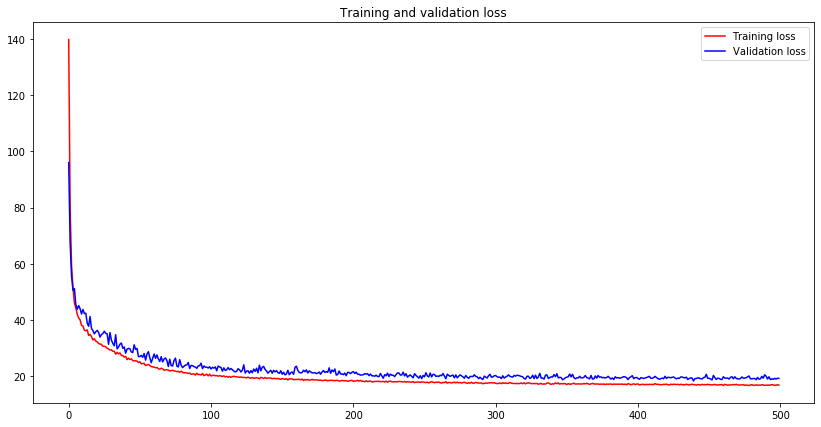

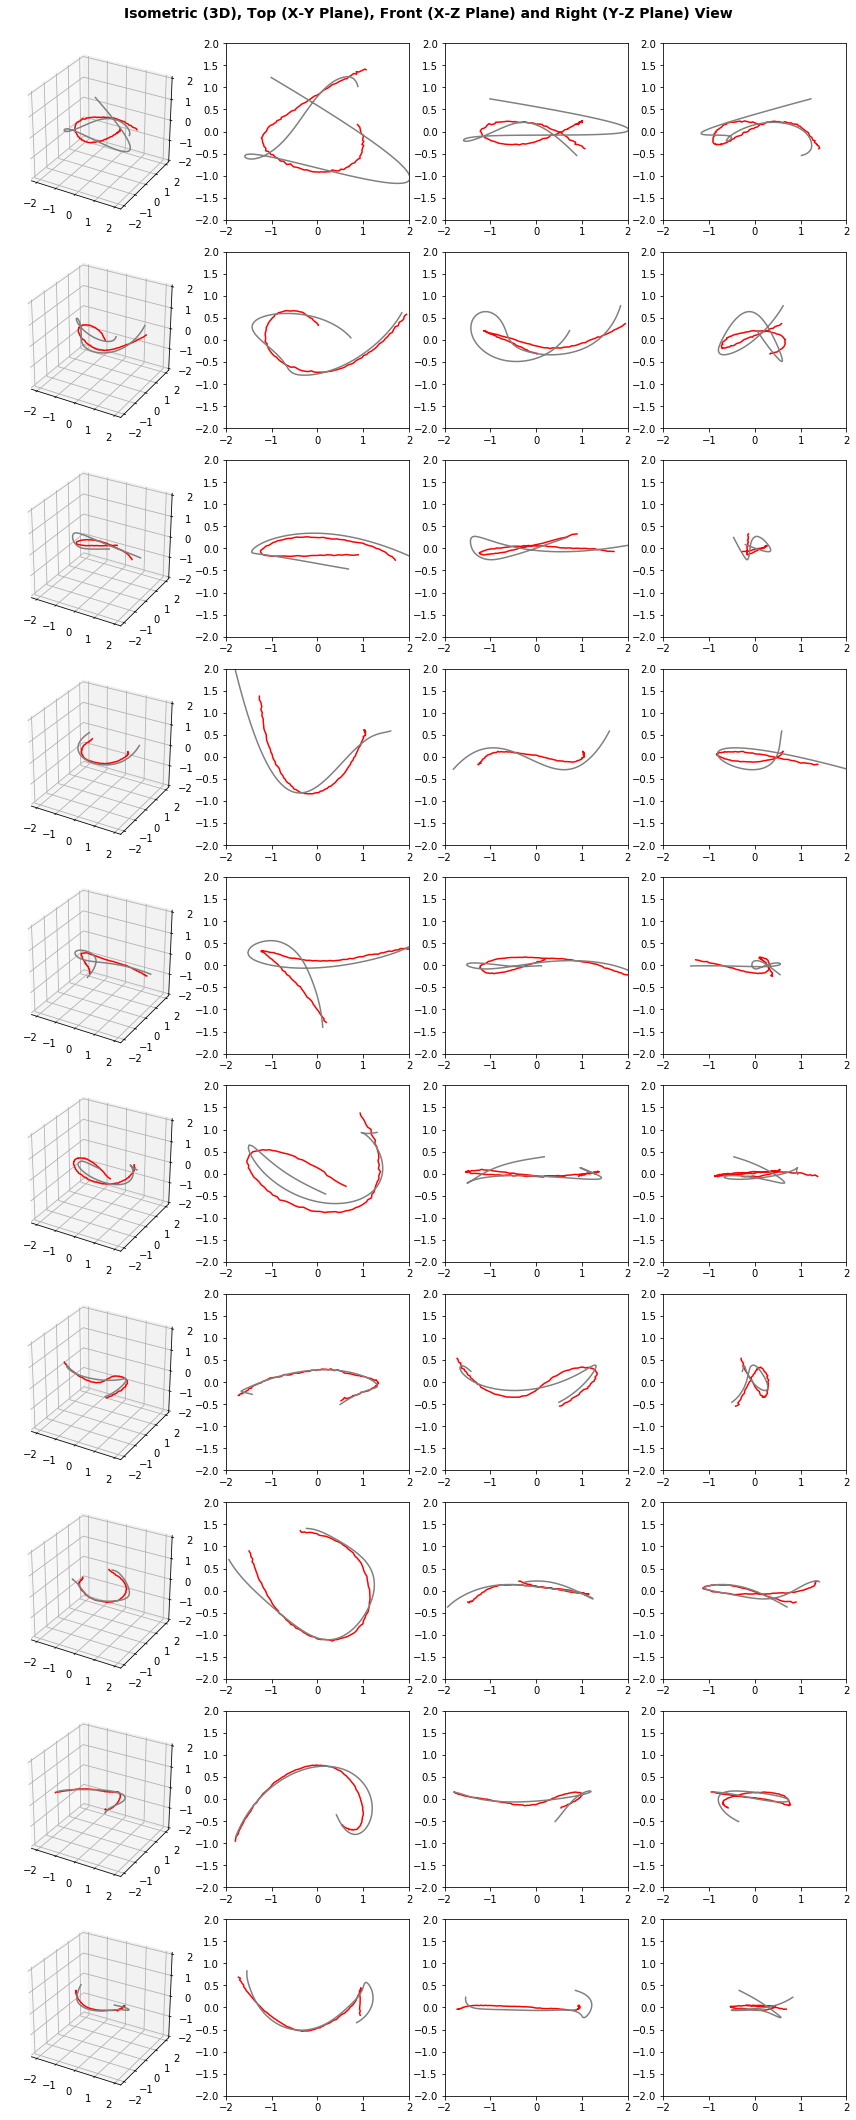

In [14]:
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.losses import mse

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

def reconstruction_loss(y_true, y_pred):
    return mse(y_true, y_pred)*300


def VAE_Z30():
    z_dim=30
    inp_curve=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)

    z_mu = Dense(z_dim)(x)
    z_log_var = Dense(z_dim)(x)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var) # normalize log variance to std dev

    eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],z_dim)))
    z_eps = Multiply()([z_sigma, eps])
    encoded = Add()([z_mu, z_eps])

    # Decoding
    x=Dense(150, activation='relu')(encoded)
    #x=Dense(150, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    vae = Model(inputs=[inp_curve, eps], outputs=decoded)
    encoder = Model(inputs=[inp_curve, eps], outputs=encoded)
    
    return vae, encoder

#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')
vae,_=VAE_Z30()
vae.summary()
vae.compile(optimizer='rmsprop', loss=reconstruction_loss)
train_data=vae.fit(x_train, x_train,
        shuffle=True,
        epochs=500,
        batch_size=128,
        validation_data=(x_test, x_test), verbose=0)
visualize_AE(vae, train_data, x_test)